In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

In [5]:
df = pd.read_csv('quora.csv', index_col = 'id', dtype = {'is_duplicate': int, 'qid1': int, 'qid2':int})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [7]:
df = df.dropna()

In [8]:
# validate missing value removal
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404287 non-null  int64 
 1   qid2          404287 non-null  int64 
 2   question1     404287 non-null  object
 3   question2     404287 non-null  object
 4   is_duplicate  404287 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [ ]:
# Get an idea of what 'duplicate' questions look like
concatenated_df = pd.concat([df['question1'][df['is_duplicate'] == 1], df['question2'][df['is_duplicate'] == 1]], axis=1)

In [31]:
concatenated_df.tail()

,question1,question2
id,,
404280,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...
404281,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...
404282,How does a long distance relationship work?,How are long distance relationships maintained?
404284,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...
404286,Do you believe there is life after death?,Is it true that there is life after death?


<Axes: xlabel='is_duplicate', ylabel='count'>

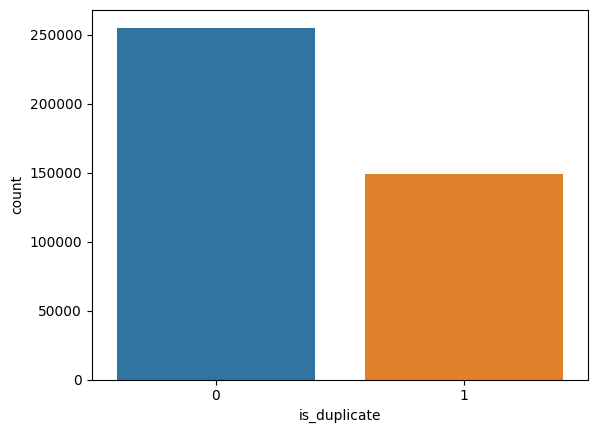

In [34]:
# check label balance
df['is_duplicate'].value_counts()
sns.countplot(data=df, x="is_duplicate")

In [1]:
print(f'Without balancing, if the model were to to guess \
 all class 0, then we would expect to see an accuracy of {round((255024/404287), 2)}.')

Without balancing, if the model were to to guess  all class 0, then we would expect to see an accuracy of 0.63.


Labels are unbalanced so they that will need to be accounted for.

In [12]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

In [13]:
#FIXME this may or may not be broken, but a better understanding of the\
# reshaping is needed.

# # random oversample to balance the labels
# over = RandomOverSampler()
# X, y = over.fit_resample(X, y)
# data = np.hstack((X, np.reshape(y, (-1, 1))))
# transformed_df = pd.DataFrame(data, columns=df.columns)

In [14]:
# # validate label balancing
# transformed_df['is_duplicate'].value_counts()

In [15]:
# Keep question1 as only feature, because model pipeline is only built for \
# one feature (at the moment)

df = df[['question1', 'is_duplicate']]

In [16]:
# train, validate, test split
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [18]:
# Convert each training, validation, and test setDataFrame into a \
# tf.data.Dataset, then shuffles and batches the data \
# (method is from tensorflow resources)

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('is_duplicate')
  df = df['question1']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
#FIXME need to figure out how to do this type transposition with more than one \
# feature

# Convert each training, validation, and test setDataFrame into a \
# tf.data.Dataset, then shuffles and batches the data.

# def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
#   dataframe = dataframe.copy()
#   labels = dataframe.pop('is_duplicate')
#   df = df[['question1', 'question2']]
#   ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   return ds

In [20]:
# Convert dfs to shuffled, batched, and prefetched ds
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

### Embedding

In [21]:
# Embed with a pre-trained model from tensorflow hub

# "Token based embedding trained on English Google News 7B corpus" \
# -> 7B = 7 billion documents
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

### Feed-forward Neural Net

In [22]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [24]:
model.evaluate(train_data)

316/316 [==============================] - 8s 7ms/step - loss: 0.6939 - accuracy: 0.4919


[0.6939108967781067, 0.4919039309024811]

In [25]:
model.evaluate(valid_data)

40/40 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.4920


[0.6939719319343567, 0.4919735789299011]

In [26]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
316/316 [==============================] - 54s 159ms/step - loss: 0.6092 - accuracy: 0.6657 - val_loss: 0.5457 - val_accuracy: 0.7297
Epoch 2/5
316/316 [==============================] - 21s 65ms/step - loss: 0.5359 - accuracy: 0.7372 - val_loss: 0.5250 - val_accuracy: 0.7391
Epoch 3/5
316/316 [==============================] - 17s 51ms/step - loss: 0.5046 - accuracy: 0.7566 - val_loss: 0.5208 - val_accuracy: 0.7455
Epoch 4/5
316/316 [==============================] - 12s 37ms/step - loss: 0.4842 - accuracy: 0.7665 - val_loss: 0.5237 - val_accuracy: 0.7414
Epoch 5/5
316/316 [==============================] - 12s 35ms/step - loss: 0.4689 - accuracy: 0.7752 - val_loss: 0.5277 - val_accuracy: 0.7471


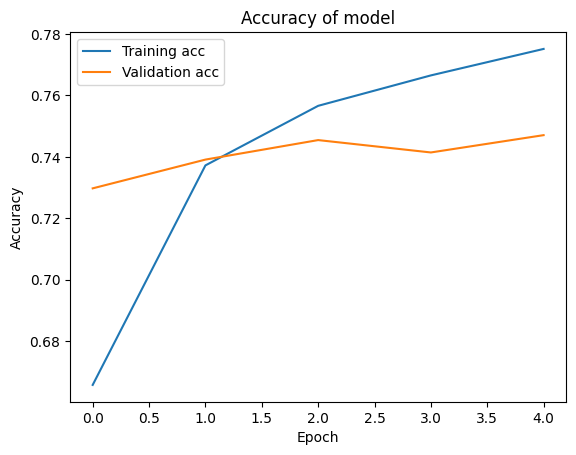

In [27]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

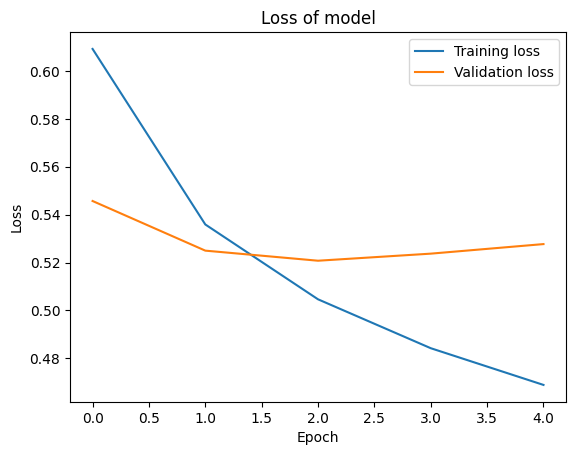

In [28]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [29]:
model.evaluate(test_data)

40/40 [==============================] - 0s 8ms/step - loss: 0.5240 - accuracy: 0.7475


[0.5240160822868347, 0.7475079894065857]

## LSTM

In [54]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [55]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'what', 'is', 'how', 'i', 'a', 'to', 'in',
       'of', 'do', 'are', 'and', 'can', 'for', 'you', 'why', 'best', 'my'],
      dtype='<U15')

In [56]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32, # because this will be the size of our LSTM
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [58]:
model.evaluate(train_data)
model.evaluate(valid_data)

40/40 [==============================] - 4s 106ms/step - loss: 0.6938 - accuracy: 0.4278


[0.6937944293022156, 0.4277622401714325]

In [67]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
316/316 [==============================] - 91s 282ms/step - loss: 0.5171 - accuracy: 0.7460 - val_loss: 0.5257 - val_accuracy: 0.7392
Epoch 2/5
316/316 [==============================] - 86s 269ms/step - loss: 0.5145 - accuracy: 0.7475 - val_loss: 0.5238 - val_accuracy: 0.7382
Epoch 3/5
316/316 [==============================] - 84s 265ms/step - loss: 0.5117 - accuracy: 0.7491 - val_loss: 0.5245 - val_accuracy: 0.7395
Epoch 4/5
316/316 [==============================] - 85s 267ms/step - loss: 0.5090 - accuracy: 0.7504 - val_loss: 0.5237 - val_accuracy: 0.7389
Epoch 5/5
316/316 [==============================] - 85s 268ms/step - loss: 0.5067 - accuracy: 0.7520 - val_loss: 0.5238 - val_accuracy: 0.7398


In [68]:
model.evaluate(test_data)

40/40 [==============================] - 4s 91ms/step - loss: 0.5235 - accuracy: 0.7400


[0.5234501361846924, 0.7400380969047546]

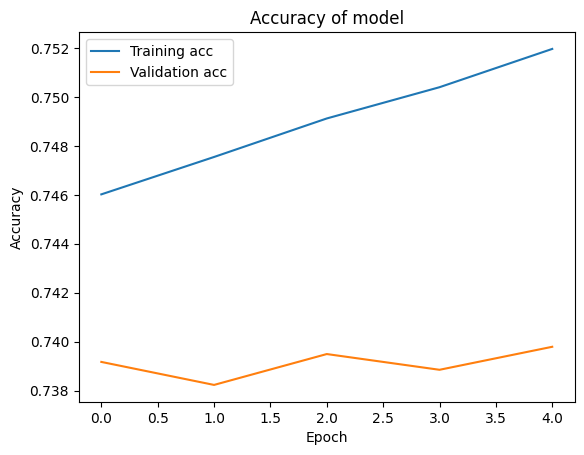

In [69]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

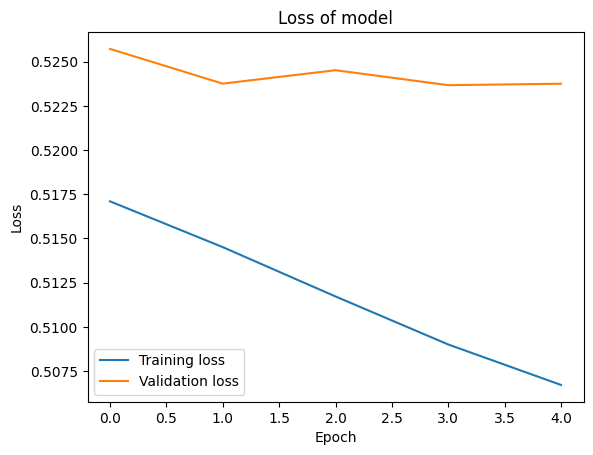

In [70]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()